In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import concatenate, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.utils import plot_model

In [28]:
def conv_with_Batch_Normalisation(prev_layer , nbr_kernels , filter_Size , strides =(1,1) , padding = 'same'):
    x = Conv2D(filters=nbr_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x

In [29]:
def StemBlock(prev_layer):
    x = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 32, filter_Size=(3,3) , strides=(2,2))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 32, filter_Size=(3,3))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 64, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 80, filter_Size=(1,1))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 192, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    return x  

In [30]:
def InceptionBlock_A(prev_layer  , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=48, filter_Size=(1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels=64, filter_Size=(3,3)) # may be 3*3
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=64, filter_Size=(1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis=3)
    
    return output

In [31]:
def InceptionBlock_B(prev_layer , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))    
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 192, filter_Size = (7,1))
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output

In [32]:
def InceptionBlock_C(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 448, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,3))
    branch1_1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (1,3))    
    branch1_2 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,1))
    branch1 = concatenate([branch1_1 , branch1_2], axis = 3)
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size = (1,1))
    branch2_1 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (1,3))
    branch2_2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (3,1))
    branch2 = concatenate([branch2_1 , branch2_2], axis = 3)
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 320, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output

In [33]:
def ReductionBlock_A(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3) , strides=(2,2) ) #, padding='valid'
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size=(3,3) , strides=(2,2) )
    
    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

In [34]:
def ReductionBlock_B(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1) )
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid' )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

In [35]:
def auxiliary_classifier(prev_Layer):
    x = AveragePooling2D(pool_size=(5,5) , strides=(3,3)) (prev_Layer)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 128, filter_Size = (1,1))
    x = Flatten()(x)
    x = Dense(units = 768, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units = 1000, activation='softmax') (x)
    return x

In [118]:
def InceptionV3():
    input_layer = Input(shape=(128, 128 , 3))
    
    x = StemBlock(input_layer)
    
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 32)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    
    x = ReductionBlock_A(prev_layer = x )
    
    x = InceptionBlock_B(prev_layer = x  , nbr_kernels = 128)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 192)
    
    Aux = auxiliary_classifier(prev_Layer = x)
    
    x = ReductionBlock_B(prev_layer = x)
    
    x = InceptionBlock_C(prev_layer = x)
    x = InceptionBlock_C(prev_layer = x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=2048, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    logits = Dense(units=9, name='logits')(x)
    x = Activation('softmax')(logits)

    model = Model(inputs = input_layer , outputs = x , name = 'Inception-V3')

    return model

In [119]:
model = InceptionV3()

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "Inception-V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_570 (Conv2D)            (None, 64, 64, 32)   896         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_570 (Batch  (None, 64, 64, 32)  128         ['conv2d_570[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [38]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2

In [39]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [40]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [41]:
DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [92]:
data = []
# path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

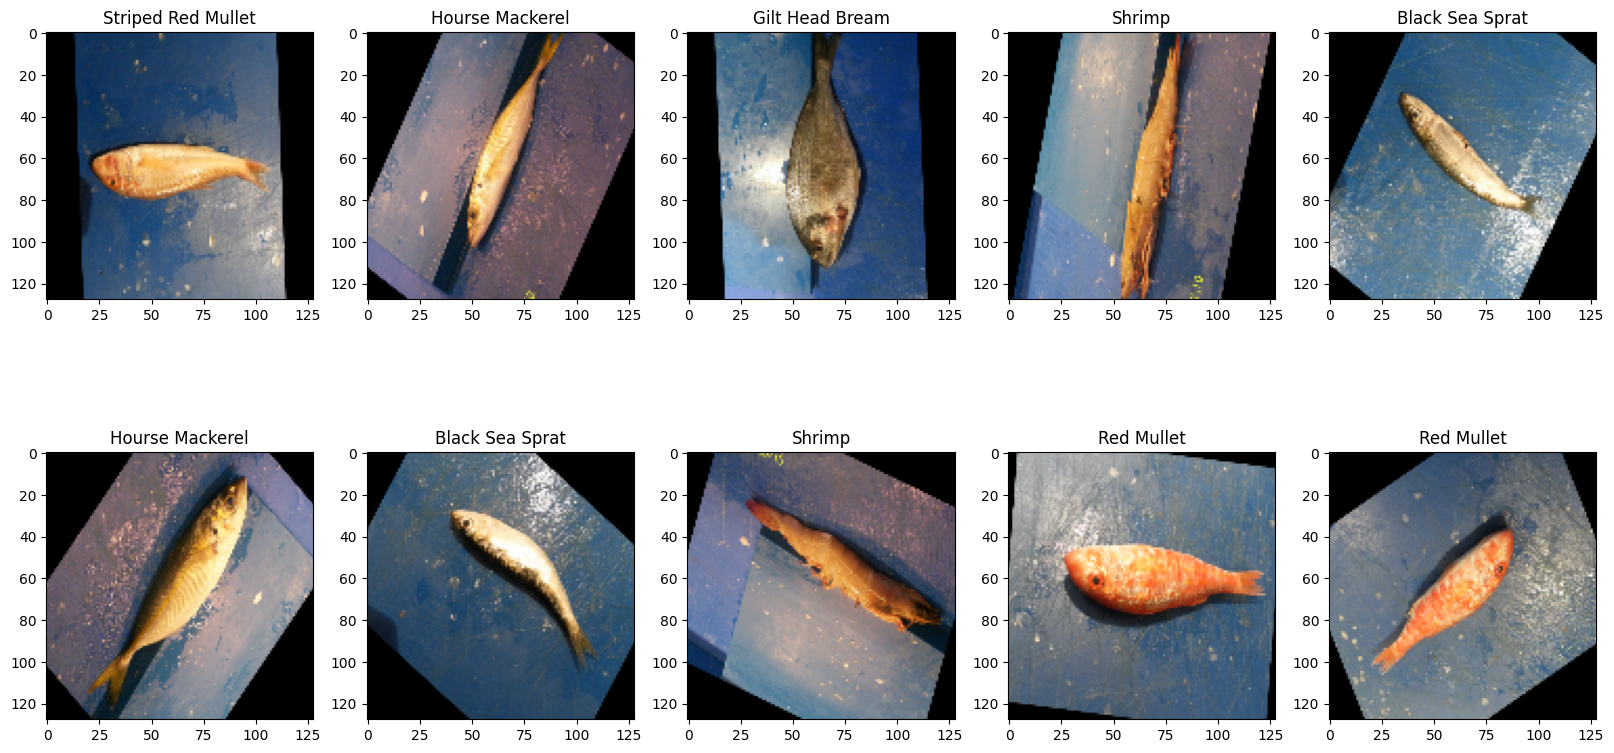

In [93]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [94]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [95]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [96]:
from keras.utils import to_categorical

labels = to_categorical(labels, num_classes=9)

In [110]:
labels.shape

(9000, 9)

In [97]:
# reshape images
images = np.array(images)
# images = images.reshape(images.shape[0], 150, 150, 3)
images = images.reshape(images.shape[0], 128, 128, 3)
images.shape

(9000, 128, 128, 3)

In [98]:
# chuẩn hóa images
images = images.astype('float32') / 255.0

In [99]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1000, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((8000, 128, 128, 3), (1000, 128, 128, 3), (8000, 9), (1000, 9))

In [100]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 889, 1: 889, 2: 889, 3: 889, 4: 889, 5: 889, 6: 889, 7: 888, 8: 889}

In [101]:
data_test = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
# path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset'
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [102]:
# shuffle data_test
import random
random.shuffle(data_test)

In [103]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [104]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [105]:
test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [106]:
# reshape images
test_images = np.array(test_images)
# images = images.reshape(images.shape[0], 150, 150, 3)
test_images = test_images.reshape(test_images.shape[0], 128, 128, 3)
test_images.shape

(430, 128, 128, 3)

In [107]:
test_images = test_images.astype('float32') / 255.0

In [108]:
train_labels.shape, test_labels.shape

((8000, 9), (430, 9))

In [112]:
train_images.shape, test_images.shape

((8000, 128, 128, 3), (430, 128, 128, 3))

In [121]:
train_ds = (train_images.batch(batch_size=32, drop_remainder=True))
val_ds = (val_images.batch(batch_size=32, drop_remainder=True))
test_ds = (test_images.batch(batch_size=32, drop_remainder=True))

AttributeError: 'numpy.ndarray' object has no attribute 'batch'

In [120]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10


ValueError: in user code:

    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(288,) and logits.shape=(32, 9)
